# 2. 캐글 신용카드 사기 검출
- [csv 파일](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- 사기 트랜잭션이 0.172%로 매우 적은 불균형한 데이터 분포
- 실제 사기를 사기로 예측하는 **재현율**이 중요한 지표

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('../data/creditcard.csv')
card_df.head(3) # Class 0이 정상, 1이 사기 거래

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.shape

(284807, 31)

## 데이터 전처리 1
- Time column을 버리고 분할

In [3]:
from sklearn.model_selection import train_test_split

def get_processed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [4]:
def get_train_test_dataset(df=None):
    df_copy = get_processed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                       test_size=0.3, random_state=0,
                                                       stratify=y_target)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [6]:
print('학습 데이터 레이블 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('테스트 데이터 레이블 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


## 로지스틱 회귀

### 평가 함수 정의

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8846, 재현율: 0.6216, F1: 0.7302, AUC:0.9598


## LightGBM

### 모델에 학습-예측-평가하는 과정을 함수로 정의

In [9]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


## 데이터 전처리 2
- 스케일링 (표준화)

<AxesSubplot:xlabel='Amount', ylabel='Density'>

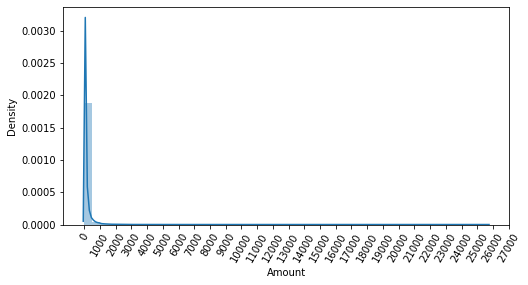

In [11]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [12]:
from sklearn.preprocessing import StandardScaler

def get_processed_df(df=None):
    df_copy = df.copy()
    # 표준화
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount Scaled', amount_n) # 첫번째 열에 삽입
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [14]:
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9779


## 데이터 전처리 3
- 스케일링 (로그 변환)

In [15]:
def get_processed_df(df=None):
    df_copy = df.copy()
    # 로그 변환, log1p(x) = log_e(x+1)
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [17]:
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9796


<AxesSubplot:xlabel='Amount Scaled', ylabel='Density'>

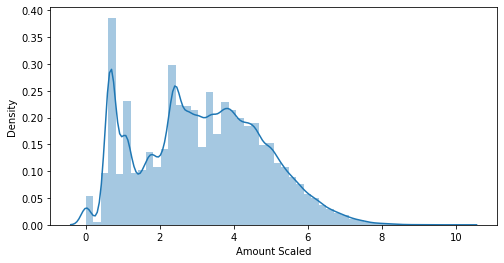

In [18]:
plt.figure(figsize=(8, 4))
sns.distplot(get_processed_df(card_df)['Amount Scaled'])

## 데이터 전처리 4
- label과 상관관계가 높은 feature의 이상치 제거

### 상관관계 시각화

<AxesSubplot:>

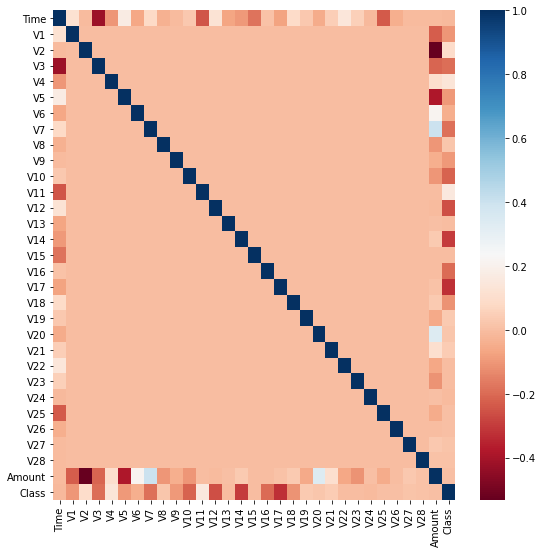

In [19]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

V14와 V17이 Class와 상관관계가 크다

### 이상치 제거
- Tukey : IQR의 1.5배
- Carling : 중앙값의 2.3배

In [20]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column] # 사기꾼 데이터의 V14
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [21]:
outlier_index = get_outlier(card_df, 'V14')
print(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [22]:
card_df.loc[outlier_index, 'V14']

8296   -19.214325
8615   -18.822087
9035   -18.493773
9252   -18.049998
Name: V14, dtype: float64

<AxesSubplot:xlabel='V14', ylabel='Density'>

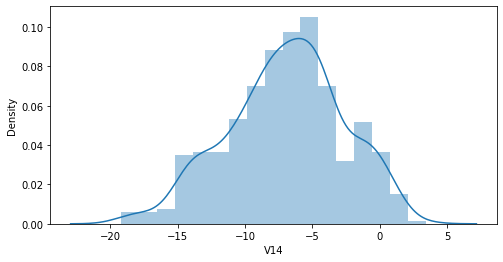

In [23]:
plt.figure(figsize=(8, 4))
sns.distplot(card_df[card_df['Class']==1]['V14'])

<AxesSubplot:xlabel='V14'>

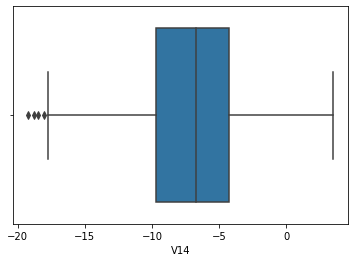

In [24]:
sns.boxplot(card_df[card_df['Class']==1]['V14'])

In [25]:
def get_processed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    # 이상치 제거
    outlier_index = get_outlier(df_copy, 'V14')
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [26]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC:0.9780


## 데이터 전처리 5
- 오버 샘플링 : 적은 레이블을 가진 데이터 셋을 많은 레이블을 가진 데이터 셋 수준으로 증식
- 언더 샘플링 : 많은 \~~ 적은 ~~ 감소
- SMOTE
    - **S**ynthetic **M**inority **O**ver-sampling **Te**chnique
    - 적은 데이터 셋의 데이터들의 KNN을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터 생성

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 전 :', X_train.shape, y_train.shape)
print('SMOTE 후 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 후 레이블 분포 :\n', pd.Series(y_train_over).value_counts())

SMOTE 전 : (199362, 29) (199362,)
SMOTE 후 : (398040, 29) (398040,)
SMOTE 후 레이블 분포 :
 0    199020
1    199020
Name: Class, dtype: int64


In [29]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    
    # 위 예제에서도 보이듯이 임계값의 개수가 정밀도나 재현율보다 적음
    # 따라서 임계값 개수만큼만 그래프를 그리기 위함
    threshold_boundary = thresholds.shape[0]
    
    # plt.plot(x축 변수, y축 변수)
    plt.plot(thresholds, precisions[:threshold_boundary],
             linestyle='--', label='precision')
    plt.plot(thresholds, recalls[:threshold_boundary],
            label='recall')
    
    # X축 scale을 0.1 단위로
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label, legend, grid
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    
    plt.show()

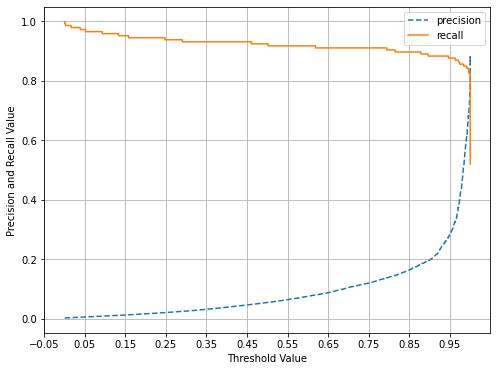

In [33]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [34]:
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

### LightGBM 예측 성능 ###
오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


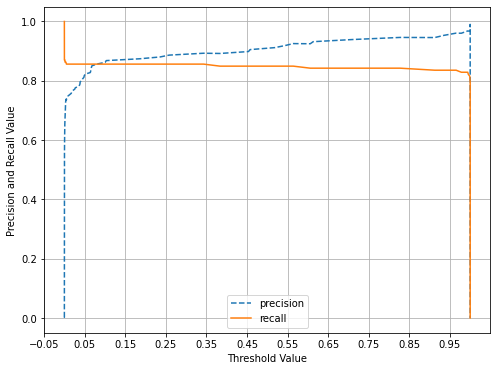

In [35]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1])

SMOTE는 일반적으로 재현율은 높이고 정밀도는 낮춘다.